<a href="https://colab.research.google.com/github/Rogerio5/Transfer-Learning-Project-in-Python-/blob/main/Projeto_de_Transfer_Learning_em_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.5317 - loss: 0.7085 - val_accuracy: 0.6197 - val_loss: 0.6552
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.5759 - loss: 0.6755 - val_accuracy: 0.6346 - val_loss: 0.6457
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 574s 985ms/step - accuracy: 0.6041 - loss: 0.6662 - val_accuracy: 0.6470 - val_loss: 0.6375
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 573s 984ms/step - accuracy: 0.6151 - loss: 0.6581 - val_accuracy: 0.6492 - val_loss: 0.6330
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 625s 990ms/step - accuracy: 0.6116 - loss: 0.6568 - val_accuracy: 0.6556 - val_loss: 0.6291
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 614s 975ms/step - accuracy: 0.6150 - loss: 0.6528 - val_accuracy: 0.6634 - val_loss: 0.6252
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 630s 990ms/step - accuracy: 0.6231 - loss: 0.6531 - val_accuracy: 0.6589 - val_loss: 0.6242
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 566s 972ms/step - accuracy: 0.6267 - loss:

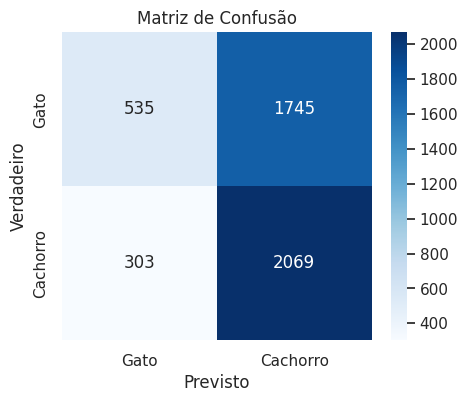

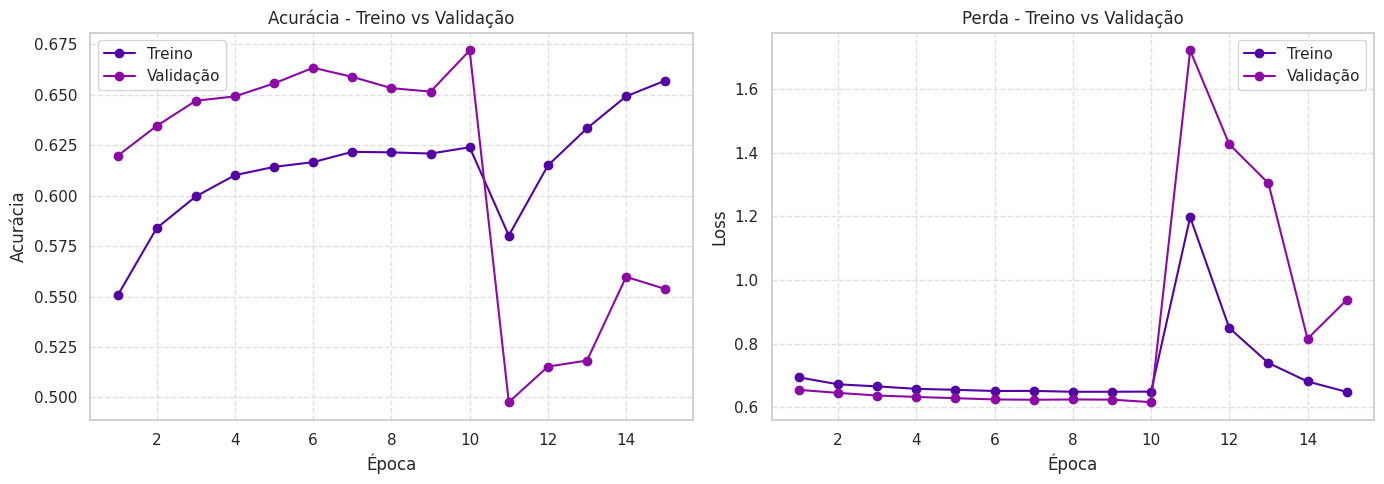

In [17]:
# ===========================================
# 0. Imports
# ===========================================
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import cv2
import os
import random
from IPython.display import Image as IPyImage, display

# ===========================================
# 1. Configurações iniciais
# ===========================================
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = ["Gato", "Cachorro"]

# ===========================================
# 2. Funções de pré-processamento
# ===========================================
def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

# ===========================================
# 3. Carregar datasets
# ===========================================
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# ===========================================
# 4. Pipeline otimizada
# ===========================================
ds_train = ds_train.map(format_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.map(format_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ===========================================
# 5. Criar base pré-treinada
# ===========================================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# ===========================================
# 6. Construir modelo completo (data augmentation dentro do modelo)
# ===========================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# ===========================================
# 7. Compilar modelo
# ===========================================
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ===========================================
# 8. Callbacks
# ===========================================
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('melhor_modelo.keras', save_best_only=True)
]

# ===========================================
# 9. Treinamento inicial
# ===========================================
history = model.fit(ds_train, epochs=10, validation_data=ds_test, callbacks=callbacks)

# ===========================================
# 10. Avaliar modelo inicial
# ===========================================
loss, acc = model.evaluate(ds_test)
print(f"Acurácia inicial: {acc:.2%}")

# ===========================================
# 11. Fine-Tuning
# ===========================================
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
fine_tune_epochs = 5
total_epochs = len(history.epoch) + fine_tune_epochs

history_fine = model.fit(
    ds_train,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=ds_test,
    callbacks=callbacks
)

# ===========================================
# 12. Avaliação final
# ===========================================
loss, acc = model.evaluate(ds_test)
print(f"Acurácia após Fine-Tuning: {acc:.2%}")

# ===========================================
# 13. Salvar modelo final
# ===========================================
model.save("modelo_final.keras")

# ===========================================
# 14. Exportar para TensorFlow Lite com quantização dinâmica
# ===========================================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("modelo_final_quantizado.tflite", "wb") as f:
    f.write(tflite_model)
print("Modelo exportado para TensorFlow Lite com quantização dinâmica!")

# ===========================================
# 15. Métricas e Matriz de Confusão
# ===========================================
y_true, y_pred = [], []
for imagens, labels in ds_test:
    preds = model.predict(imagens)
    y_true.extend(labels.numpy())
    y_pred.extend([1 if p > 0.5 else 0 for p in preds])

report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
print(pd.DataFrame(report).transpose())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()

# ===========================================
# 16. Gráficos de Acurácia e Perda
# ===========================================
acc_train = history.history['accuracy'] + history_fine.history['accuracy']
acc_val = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss_train = history.history['loss'] + history_fine.history['loss']
loss_val = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(1, len(acc_train) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_train, label='Treino', marker='o')
plt.plot(epochs_range, acc_val, label='Validação', marker='o')
plt.title('Acurácia - Treino vs Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_train, label='Treino', marker='o')
plt.plot(epochs_range, loss_val, label='Validação', marker='o')
plt.title('Perda - Treino vs Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ===========================================
# 17. Grad-CAM
# ===========================================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1"):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_gradcam_image(img_path, model, last_conv_layer_name="Conv_1", output_path="gradcam_resultado.jpg"):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    original = cv2.imread(img_path)
    original = cv2.resize(original, IMG_SIZE)
    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)
    cv2.imwrite(output_path, superimposed_img)
    print(f"Imagem com Grad-CAM salva em: {output_path}")

# Geração automática de Grad-CAM